In [2]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import gridspec
import scipy
import numpy as np
import time
style.use('ggplot')
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
plt.rcParams['text.usetex'] = True

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]
colors = {'official': 'green',
         'community': blue,
         'Oldstable': PALETTE_BASE[-4],
          'Stable': PALETTE_BASE[-1],
          'Testing': PALETTE_BASE[-6],
          'Higher': 'red',
          'Medium': flatui[1],
          'Lower': flatui[0]
         }
# Considered period for the analysis
first_date="2016-07-01"
last_date="2019-06-01"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)
release_map={'jessie':'Oldstable',
             'stretch':'Stable',
             'buster':'Testing'}
type_map={'o':'official',
          'c':'community'}

# All images and tags

In [3]:
df = pd.read_csv('../../../docker_emse/csv/prepared_data/compact.csv.gz')

In [5]:
df.query('kind=="official"')[['image','hash']].image.size

22760

In [6]:
df.query('kind=="official"')[['image','hash']].set_index('image').drop_duplicates().shape

(12427, 1)

In [7]:
df.query('kind=="community"')[['image','hash']].image.size

5718715

In [8]:
df.query('kind=="community"')[['image','hash']].set_index('image').drop_duplicates().shape

(4381972, 1)

# Load images

In [3]:
images = pd.read_csv('../../../docker_emse/csv/for_analysis/installed_packages.csv',
                    usecols = ['image','last_updated','type','release'])
images.drop_duplicates(inplace=True)
images.shape

(140498, 4)

In [4]:
images['slug'] = images['image'].apply(lambda x: '/'.join(x.split(':')[0:2]))

In [5]:
images.replace({'type': type_map}, inplace=True)
images.replace({'release': release_map}, inplace=True)

In [4]:
images.slug.unique().size

14007

In [34]:
print(images.query('type == "o"').image.unique().size, images.query('type == "c"').image.unique().size)

(9330, 131168)

# Load popularity

In [ ]:
pop = pd.concat([pd.read_csv('../../../docker_emse/csv/'+file+'.zip', usecols=['slug','popularity']) 
                        for file in ['official_images','community_images']])
pop.shape

In [ ]:
pop.popularity.describe().apply(lambda x: format(x, 'f'))

In [ ]:
mask = pop.slug.isin(images.slug)
pop = pop[mask]

In [ ]:
images = (images
          .merge(pop,
                on = 'slug',
                how = 'left')
         )
images.shape

In [ ]:
images.popularity.describe().apply(lambda x: format(x, 'f'))

### Let's check when images were last updated

In [6]:
images = images.query('last_updated != "None"')
images['last_updated'] = pd.to_datetime(images['last_updated'])

In [7]:
df_tmp=(images.
        groupby(['release','last_updated','type']).
        count().
        reset_index()
       )

df_tmp = (df_tmp
          .drop('slug', axis=1)
          .pivot_table(index=['last_updated','type'], columns='release', values='image')
          .fillna(0)
          .reset_index())

/home/neglectos/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


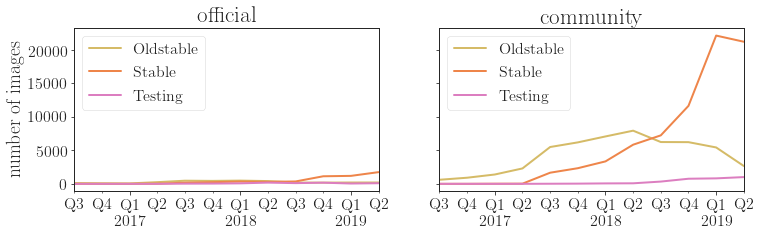

In [9]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(12,3)
for j, genre in enumerate(['official','community']):
    df_=(df_tmp.
         query('type =="{}"'.format(genre)).
         groupby(pd.Grouper(key='last_updated', freq='1Q'))[['Oldstable','Stable','Testing']].
         agg(sum)
        )    
    ax=df_.plot(ax=axes[j], linewidth=2, colors=[colors[x] for x in ['Oldstable','Stable','Testing']])

    ax.set(
        xlabel='',
        #ylim=(0,20),
        ylabel='number of images',
        title=genre,
        xlim=date_period)
    #plt.yticks(pd.np.arange(0, 50, 20))
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/number_images.pdf', bbox_inches='tight', facecolor='white')

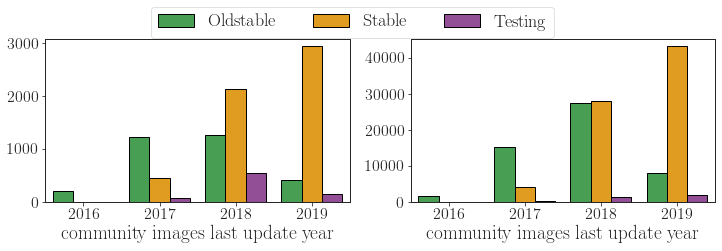

In [103]:
images['year'] = images['last_updated'].apply(lambda x: str(x).split('-')[0])
figure, axes = plt.subplots(1, 2, sharex=True, sharey=False)
figure.set_size_inches(12,3)

df_tmp=(images.
        groupby(['release','year','type']).
        count().
        reset_index()
       )

df_tmp = (df_tmp
        .replace({'release': release_map})
       )
for i, t in enumerate(['official','community']):
    ax = sns.barplot(
        y="image", x='year', hue='release', data=df_tmp.query('type=="'+t+'"'), 
        palette=flatui, linewidth=1,  ax=axes[i], hue_order=['Oldstable','Stable','Testing'])
    #ax.set_ylim(0,6000)
    for patch in ax.patches:
        patch.set_edgecolor('black')
    if t =='o':
        ax.set_xlabel("official images last update year")
        ax.set_ylabel('number of images')
        plt.yticks(pd.np.arange(0, 5000, 500))
        continue

    else:
        ax.set_xlabel("community images last update year")
        ax.set_ylabel("")
        plt.yticks(pd.np.arange(0, 50000, 10000))
    #for patch in ax.patches:
    #    patch.set_edgecolor('black')
    ax.legend(loc='upper right', bbox_to_anchor=(1.7, 1.25), ncol=3, fontsize=18, fancybox=True)
ax.legend(loc='upper right', bbox_to_anchor=(0.5, 1.25), ncol=3, fontsize=18, fancybox=True)
figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/last_updated.pdf', bbox_inches='tight', facecolor='white')

In [104]:
for i, t in enumerate(['official','community']):
    df_tmp=(images.query('type =="'+t+'" ')
            .groupby(['year'])
            .count()
           )
    print(df_tmp.image*100/len(images.query('type =="'+t+'" ')))

year
2016     2.132905
2017    18.531618
2018    42.047160
2019    37.288317
Name: image, dtype: float64
year
2016     1.161124
2017    14.850647
2018    43.339737
2019    40.648491
Name: image, dtype: float64


# Load packages

In [2]:
packages = pd.read_csv('../../../docker_emse/csv/for_analysis/installed_packages.csv',
                      usecols=['image','package','type','version','release'])
packages.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(46272487, 5)

In [3]:
packages.release.unique()

array(['stretch', 'buster', 'jessie'], dtype=object)

In [5]:
'number of images', packages.image.unique().size

('number of images', 140498)

In [6]:
packages[['image','type']].drop_duplicates().groupby('type').count()

,image
type,
c,131168
o,9330


In [8]:
packages[['image','type','release']].drop_duplicates().groupby(['type','release']).count()

image
type release       
c    buster    3114
     jessie   52520
     stretch  75534
o    buster     741
     jessie    3085
     stretch   5504

In [9]:
packages[['image','release']].drop_duplicates().groupby('release').count()

,image
release,
buster,3855
jessie,55605
stretch,81038


In [6]:
packages.query('type == "o"').shape, packages.query('type == "c"').shape

((2042387, 5), (44230100, 5))

In [15]:
packages.query('type == "o"').groupby('image').count()[['package']].package.median()

185.0

In [14]:
packages.query('type == "c"').groupby('image').count()[['package']].package.median()

377.0

# Vulnerabilities

In [11]:
vuls = pd.read_csv('../../../docker_emse/csv/for_analysis/vulnerabilities.csv')
vuls = vuls.drop('archive', axis=1).drop_duplicates()
vuls.shape

(63601, 7)

In [12]:
urgency_map={'low**':'Low',
            'low*':'Low',
            'low':'Low',
            'medium**':'Medium',
            'medium**':'Medium',
            'medium':'Medium',
            'high**':'High',
            'high*':'High',
            'high':'High',
            'unimportant': pd.np.nan,
            'not yet assigned': pd.np.nan,
            'end-of-life': pd.np.nan,
           }

vuls = vuls.query('status != "undetermined"').copy()
vuls = (vuls
        .replace({'urgency': urgency_map})
        .dropna(subset=['urgency'])
        .drop_duplicates()
       )

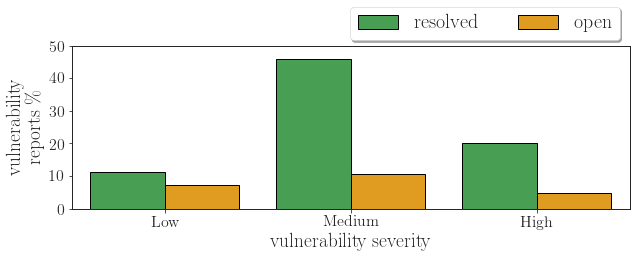

In [16]:
df_tmp=vuls.groupby(['urgency','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(vuls)
df_tmp=df_tmp.sort_values('urgency', ascending=False)

ax = sns.barplot(x="urgency", 
                 y="source", 
                 hue="status", 
                 order=['Low','Medium','High'],
                 hue_order=['resolved', 'open'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(10,3)
ax.set_xlabel("vulnerability severity ")
ax.set_ylabel('vulnerability\n reports \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/all_vuls.pdf', bbox_inches='tight', facecolor='white')

In [18]:
vuls.source.unique().size

557

In [17]:
vuls.groupby(['status']).count().source*100.0/len(vuls)

status
open        22.900451
resolved    77.099549
Name: source, dtype: float64

In [19]:
vuls.groupby(['status']).count().source

status
open        10621
resolved    35758
Name: source, dtype: int64

In [20]:
vuls.groupby(['urgency']).count().source*100.0/len(vuls)

urgency
High      24.970353
Low       18.523470
Medium    56.506177
Name: source, dtype: float64

# Bugs

In [21]:
bugs = pd.read_csv('../../../docker_emse/csv/for_analysis/bugs.csv')
bugs.drop_duplicates(inplace=True)
bugs.shape

(371639, 10)

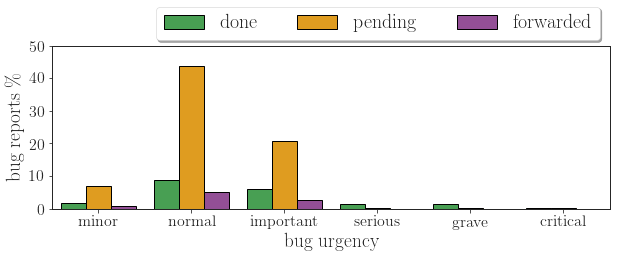

In [31]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="source", 
                 hue="status", 
                 hue_order = ['done','pending','forwarded'],
                 order=['minor', 'normal', 'important', 'serious','grave','critical'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(10,3)
ax.set_xlabel("bug urgency")
ax.set_ylabel('bug reports \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.figure.savefig('/home/neglectos/Desktop/repositories/docker_emse/figures/all_bugs.pdf', bbox_inches='tight', facecolor='white')

In [32]:
bugs.source.unique().size

3400

In [22]:
bugs.groupby(['status']).count().source*100.0/len(bugs)

status
done         19.530512
forwarded     8.567454
pending      71.902034
Name: source, dtype: float64

In [23]:
bugs.groupby(['status']).count().source

status
done          72583
forwarded     31840
pending      267216
Name: source, dtype: int64

In [33]:
bugs.groupby(['severity']).count().source*100.0/len(bugs)

severity
critical      0.208805
grave         1.375797
important    29.434209
minor         9.502770
normal       57.840001
serious       1.638418
Name: source, dtype: float64

In [14]:
severity_map={'minor':'Lower',
            'normal':'Lower',
            'important':'Higher',
            'grave':'Higher',
            'serious':'Higher',
            'critical':'Higher',
           }

bugs = (bugs
        .replace({'severity': severity_map})
        .drop_duplicates()
       )

Text(0.18, 1.15, 'Status:')

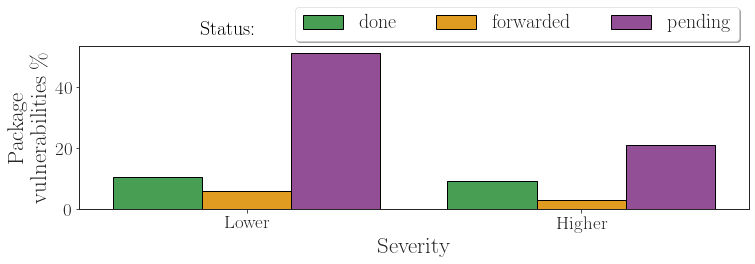

In [15]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['source']=df_tmp['source']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="source", 
                 hue="status", 
                 hue_order = ['done','forwarded','pending'],
                 #order=['Lower', 'Medium', 'Higher'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Package \n vulnerabilities \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')
#ax.figure.savefig('../../../seneca_research/docker_debian/figures/all_vuls.pdf', bbox_inches='tight', facecolor='white')